In [1]:
import casadi as ca


class Bezier:
    """
    https://en.wikipedia.org/wiki/B%C3%A9zier_curve
    """

    def __init__(self, P: ca.SX, T: ca.SX):
        self.P = P  # control points
        self.m = P.shape[0]  # dimension of point
        self.n = P.shape[1] - 1  # order of bezier curve
        self.T = T  # time for leg

    def eval(self, t):
        # https://en.wikipedia.org/wiki/De_Casteljau%27s_algorithm
        beta = t / self.T
        A = ca.SX(self.P)
        for j in range(1, self.n + 1):
            for k in range(self.n + 1 - j):
                A[:, k] = A[:, k] * (1 - beta) + A[:, k + 1] * beta
        return A[:, 0]

    def deriv(self, m=1):
        D = ca.SX(self.P)
        for j in range(0, m):
            D = (self.n - j) * ca.horzcat(
                *[D[:, i + 1] - D[:, i] for i in range(self.n - j)]
            )
        return Bezier(D / self.T**m, self.T)

In [2]:
# boundary conditions
p0 = ca.SX.sym("p0", 3)
p1 = ca.SX.sym("p1", 3)
v0 = ca.SX.sym("v0", 3)
v1 = ca.SX.sym("v1", 3)
a0 = ca.SX.sym("a0", 3)
a1 = ca.SX.sym("a1", 3)
j0 = ca.SX.sym("j0", 3)
j1 = ca.SX.sym("j1", 3)

# bezier curve
C = ca.SX.sym("C", 3, 8)  # coefficients for 7th order
T = ca.SX.sym("T")  # time of leg

# bezier curve
bez = Bezier(C, T)

# right hand side for linear solve
b = ca.vertcat(p0, v0, a0, j0, p1, v1, ca.SX.zeros(3), ca.SX.zeros(3))

# left hand side for linear solve
g = ca.vertcat(
    bez.eval(0),  # pos
    bez.deriv(1).eval(0),  # vel
    bez.deriv(2).eval(0),  # accel
    bez.deriv(3).eval(0),  # jerk
    bez.eval(T),  # pos
    bez.deriv(1).eval(T),  # vel
    bez.deriv(2).eval(T),  # accel
    bez.deriv(3).eval(T),  # jerk
)

# linear solve
x_C = ca.reshape(C, C.shape[0] * C.shape[1], 1)
A = ca.jacobian(g, x_C)
sol = ca.reshape(ca.solve(A, b), C.shape[0], C.shape[1])

f_bezier = ca.Function(
    "f_bezier",
    [T, p0, v0, a0, j0, p1, v1],
    [sol],
    ["T", "p0", "v0", "a0", "j0", "p1", "v1"],
    ["C"],
)

In [3]:
C0 = f_bezier(1, [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [1, 0, 0], [0, 0, 0])

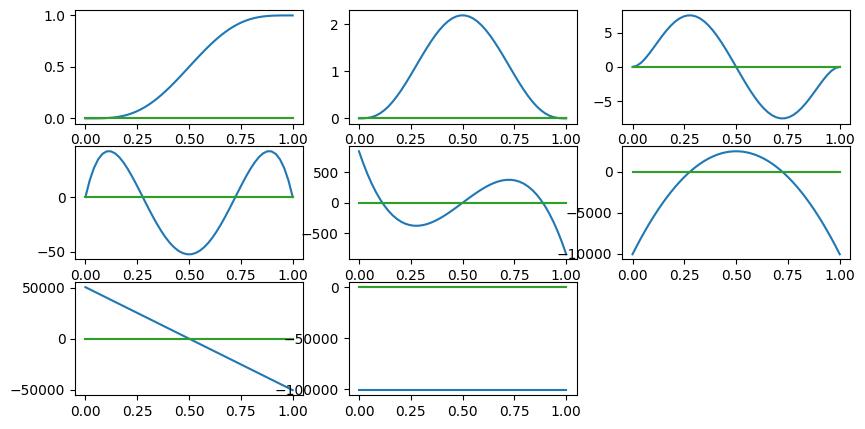

In [4]:
def plot_trajectories(C0, T_vals):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))

    for T in T_vals:
        t = np.linspace(0, T)
        bez_out = Bezier(C0, T)

        for i in range(8):
            plt.subplot(3, 3, 1 + i)
            y = np.array(
                [
                    np.array(ca.DM(bez_out.deriv(i).eval(ti)), dtype=float).reshape(-1)
                    for ti in t
                ]
            )
            plt.plot(t, y)


plot_trajectories(C0, [1])